In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image

## Load data

In [2]:
masks = glob.glob("/isbi2015/train/label/*.png")
orgs = glob.glob("/isbi2015/train/image/*.png")

In [3]:
imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):
    imgs_list.append(np.array(Image.open(image).resize((512,512))))
    
    im = Image.open(mask).resize((512,512))
    masks_list.append(np.array(im))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

In [4]:
print(imgs_np.shape, masks_np.shape)

(30, 512, 512) (30, 512, 512)


## Plot images + masks + overlay (mask over original)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

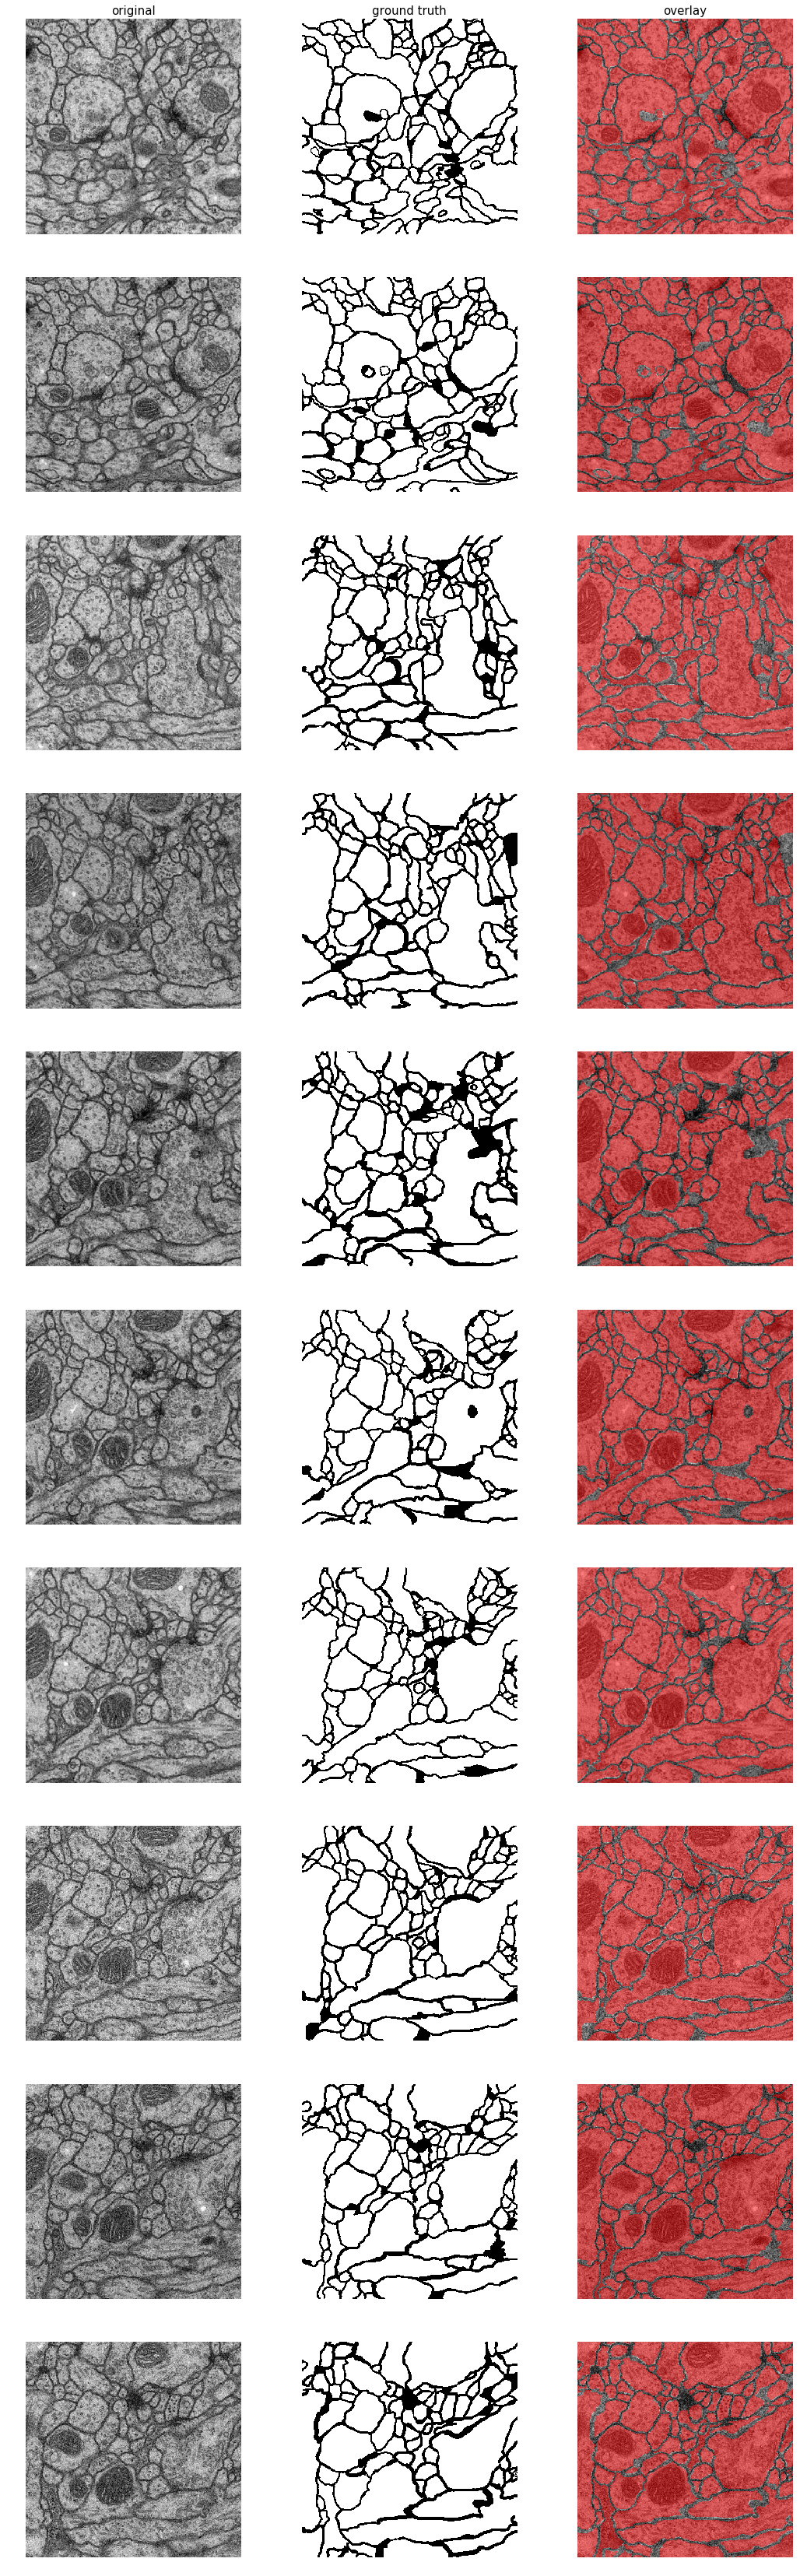

In [5]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)


## Get data into correct shape, dtype and range (0.0-1.0)

In [6]:
print(imgs_np.max(), masks_np.max())

255 255


In [7]:
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255

In [8]:
print(x.max(), y.max())

1.0 1.0


In [9]:
print(x.shape, y.shape)

(30, 512, 512) (30, 512, 512)


In [10]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(x.shape, y.shape)

(30, 512, 512) (30, 512, 512, 1)


In [11]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
print(x.shape, y.shape)

(30, 512, 512, 1) (30, 512, 512, 1)


##  Train/val split

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (15, 512, 512, 1)
y_train:  (15, 512, 512, 1)
x_val:  (15, 512, 512, 1)
y_val:  (15, 512, 512, 1)


## Prepare train generator with data augmentation

In [13]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


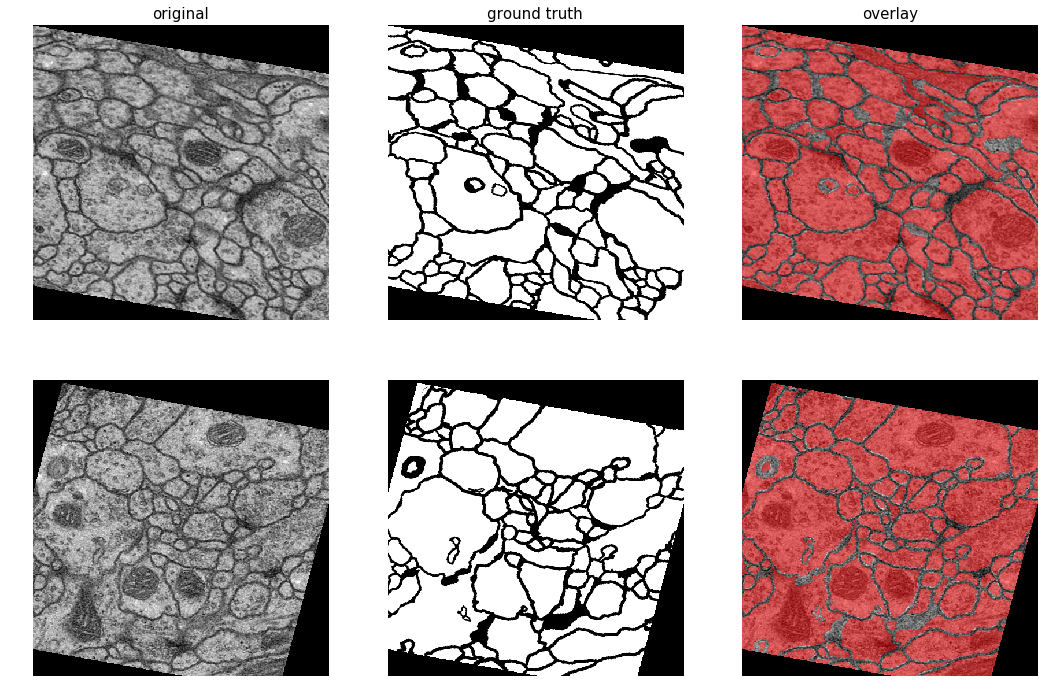

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

## Initialize network

In [15]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 512, 512, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       spatial_dropout2d[0][0]          
______________________________________________________________________________________________

## Compile + train

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [24]:
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    #optimizer=Adam(), 
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)


In [27]:
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=1,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

100/100 [==============================] - ETA: 0s - loss: 0.3787 - iou: 0.7114 - iou_thresholded: 0.7620 
Epoch 00001: val_loss did not improve from 0.37994
100/100 [==============================] - 3337s 33s/step - loss: 0.3787 - iou: 0.7114 - iou_thresholded: 0.7620 - val_loss: 0.5064 - val_iou: 0.7857 - val_iou_thresholded: 0.7947


## Plot training history

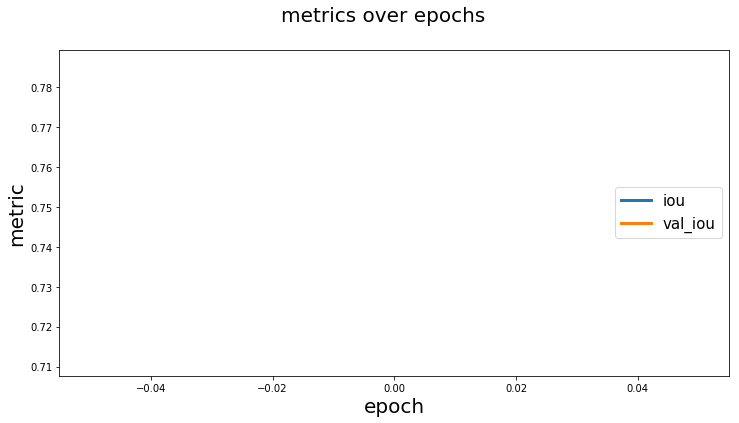

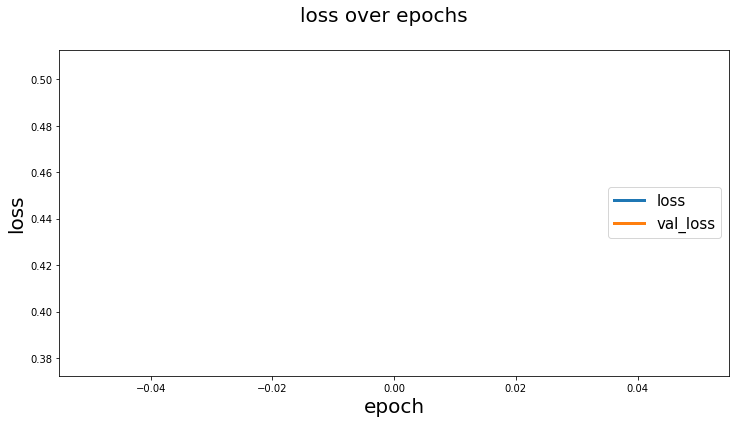

In [28]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

## Plot original + ground truth + pred + overlay (pred on top of original)

In [29]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

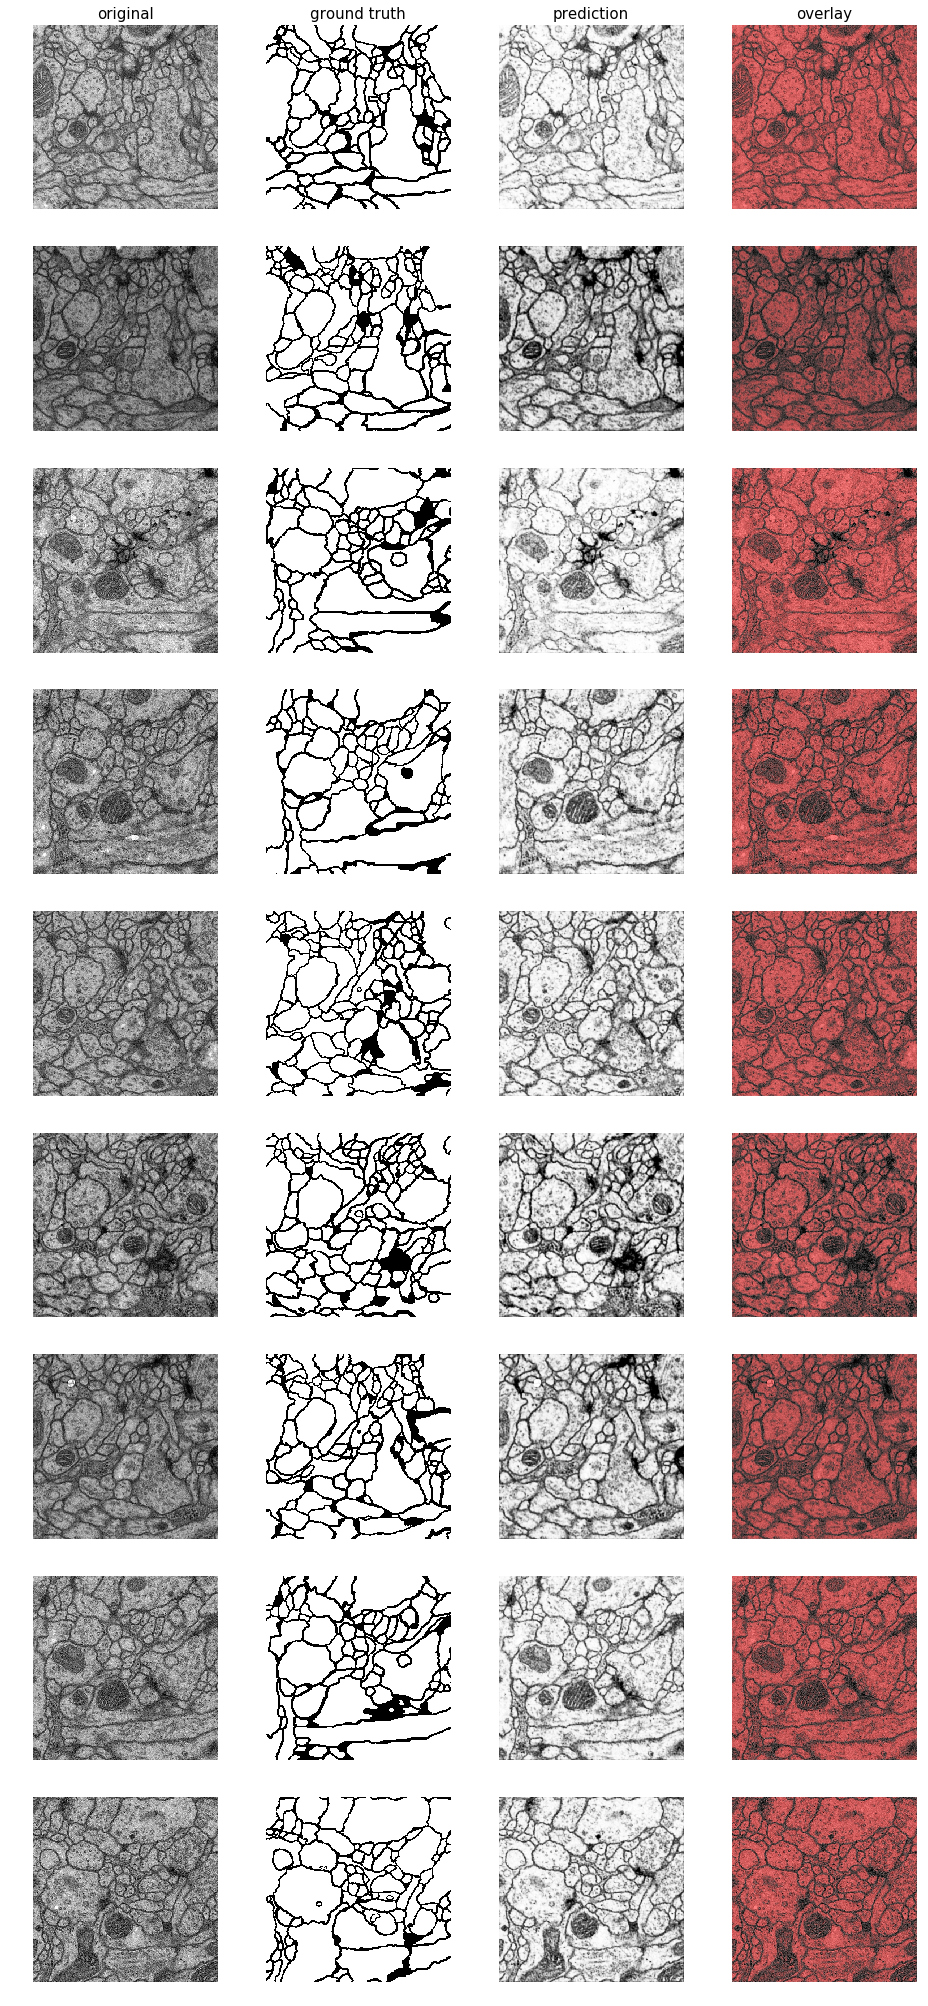

In [30]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)